In [52]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [55]:
import torch
import numpy as np

ttype = torch.cuda.DoubleTensor if torch.cuda.is_available() else torch.DoubleTensor
torch.set_default_tensor_type(ttype)

from lqg_env import LQG
from util import simulate, seiler_state_space, StateSpace, train_model, eval_model
from controllers import RNNController, OptimalController

67325.92232494568


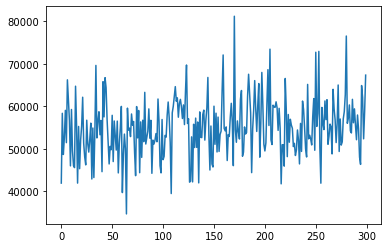

In [62]:
import matplotlib.pyplot as plt

n_epochs = 150
num_inits = 200
n_steps = 300
batch_size = 128
rnn_layers = 3
dim_hidden = 10
learning_rate = 0.01

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ss, Q, R, = seiler_state_space()

controller = RNNController(1, 1, dim_h=dim_hidden, layers=rnn_layers).to(device)
env = LQG(ss, Q, R, batch_size=batch_size)
env_x = LQG(ss, Q, R, batch_size=batch_size, observe_x=True)

opt = torch.optim.Adam(controller.parameters(), lr=learning_rate)

best = (np.inf, None)

optimal_controller = OptimalController(ss, Q, R)
loss = simulate(optimal_controller, env_x, n_steps).detach().cpu().numpy()
# print("optimal:", np.mean(loss))
print(loss[-1])
plt.plot(np.arange(len(loss)), loss)

In [63]:
for i in range(1, 11):
    controller.load_state_dict(torch.load(f'models/rnn_best_{i}'))
    loss = simulate(controller, env, n_steps).detach().cpu().numpy()[-1].item()
    print("i:", np.log10(loss), loss)

i: 22.12934444302266 1.3469281919127375e+22
i: 20.361199138879073 2.297201752252535e+20
i: 26.075117153881337 1.1888228772185906e+26
i: 20.807251846063462 6.415815199235032e+20
i: 23.140050661409255 1.3805452988644344e+23
i: 21.52995763967472 3.3881110748377593e+21
i: 18.427627768015153 2.676873004643421e+18
i: 18.786182696371334 6.111990863607583e+18
i: 17.779000603544723 6.011745729428644e+17
i: 16.68265906016142 4.815695963566454e+16


In [64]:
controller.load_state_dict(torch.load(f'models/rnn_best_10'))

<All keys matched successfully>

In [72]:
rewards = simulate(controller, env, 300)

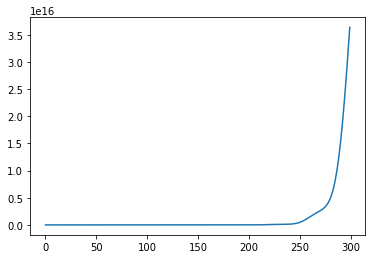

In [73]:
plt.plot(np.arange(len(rewards)), [x.mean().detach().cpu().numpy().item() for x in rewards])

In [5]:
controller.load_state_dict(torch.load(f'models/rnn_best_5'))

<All keys matched successfully>

In [11]:
losses = train_model(controller, env, opt, 300, 100)

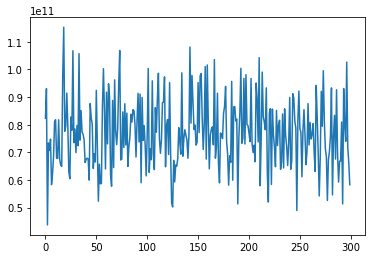

In [12]:
plt.plot(np.arange(len(losses)), losses)